In [1]:
import os
import pickle

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
def shuffle_np(x, y):
    indices = np.arange(len(y))
    np.random.shuffle(indices)
    x = x[indices]
    y = y[indices]
    return x, y


def shuffle_and_undersample(x, y):
    x, y = shuffle_np(x, y)

    min_len = np.minimum(np.sum(y == 1), np.sum(y == 0))

    x_zeros = x[(y == 0).reshape(-1)][:min_len]
    x_ones = x[(y == 1).reshape(-1)][:min_len]

    x = np.concatenate([x_zeros, x_ones])
    y = np.concatenate([np.zeros(min_len), np.ones(min_len)])
    x, y = shuffle_np(x, y)

    return x, y

In [3]:
def load_pickle_file(data_path, file_name: str = "dump.pickle"):
    with open(os.path.join(data_path, file_name), 'rb') as file:
        df = pickle.load(file)
    return df

In [4]:
def convert_to_cycle_np_array(df: pd.DataFrame, max_size: int = 200, with_welding_run: bool = False) -> tuple[np.ndarray, np.ndarray]:
    if with_welding_run:
        quality = df[["quality", "t_wn", "welding_run"]]
    else:
        quality = df[["quality", "t_wn"]]
    quality = quality.iloc[1:]
    quality = quality.iloc[::4]
    quality = quality.groupby("t_wn").first().values

    new_cycles_v = df["V"].rolling(4, step=4).mean().reset_index(drop=True).dropna()
    new_cycles_i = df["I"].rolling(4, step=4).mean().reset_index(drop=True).dropna()

    t_wn = df.t_wn.values[::4]
    t_wn = t_wn[1:]
    df = pd.DataFrame(data=np.array([t_wn, new_cycles_v.values, new_cycles_i.values]).T, columns=["t_wn", "V", "I"])
    df["t_wi"] = df.groupby("t_wn").cumcount()
    v_cycles = df.pivot(index="t_wn", columns='t_wi', values="V")
    i_cycles = df.pivot(index="t_wn", columns="t_wi", values="I")

    v_cycles = v_cycles.fillna(method="ffill", axis=1).values
    i_cycles = i_cycles.fillna(method="ffill", axis=1).values

    v_cycles = v_cycles[:, :max_size].reshape(-1, 1, max_size)
    i_cycles = i_cycles[:, :max_size].reshape(-1, 1, max_size)

    vi = np.concatenate([v_cycles, i_cycles], axis=1)
    return vi.swapaxes(1, 2), quality

In [5]:
def transform_df_to_ds(df: pd.DataFrame, max_size: int = 200, ds_type: str = "train", scaler=None) -> tuple[np.array, np.array]:
    x, y = convert_to_cycle_np_array(df, max_size=max_size)
    if ds_type == "train":
        x, y = shuffle_and_undersample(x, y)
    else:
        y = y.reshape(-1)
        x, y = shuffle_np(x, y)
    if scaler is not None:
        if ds_type == "train":
            scaler.fit(x)
        x = scaler.transform(x)
    return x, y


In [6]:
class MyScaler:

    def __init__(self) -> None:
        self.scaler = StandardScaler()

    def fit(self, x):
        s_0, s_1, s_2 = x.shape
        self.scaler.fit(x.reshape(-1, s_2))

    def transform(self, x):
        s_0, s_1, s_2 = x.shape
        x = self.scaler.transform(x.reshape(-1, s_2))
        return x.reshape(s_0, s_1, s_2)

    def inverse_transform(self, x):
        s_0, s_1, s_2 = x.shape
        x = self.scaler.inverse_transform(x.reshape(-1, s_2))
        return x.reshape(s_0, s_1, s_2)

In [7]:
def create_dataset_cycle(data_path="./data/"):
    """Create the dataset based on the cycle interval."""
    test_welding_run_good = 3
    test_welding_run_bad = 20
    
    scaler = MyScaler()
    df = load_pickle_file(data_path=data_path, file_name="welding_data_label.pickle")
    
    train_df = df[
        (df.experiment == 1) & (df.welding_run != test_welding_run_good) & (df.welding_run != test_welding_run_bad)]
    test_df = df[
        (df.experiment == 1) & ((df.welding_run == test_welding_run_good) | (df.welding_run == test_welding_run_bad))]
    
    
    x, y = transform_df_to_ds(train_df, ds_type="train", scaler=scaler)
    train_x, train_y = x[:int(len(x)*0.85)], y[:int(len(x)*0.85)]
    val_x, val_y = x[int(len(x)*0.85):], y[int(len(x)*0.85):]
    test_x, test_y = transform_df_to_ds(test_df, ds_type="val", scaler=scaler)

    return train_x, train_y, val_x, val_y, test_x, test_y, scaler



train_x, train_y, val_x, val_y, test_x, test_y, scaler = create_dataset_cycle(data_path="./")

In [8]:
train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape

((16371, 200, 2), (16371,), (2889, 200, 2), (2889,), (2620, 200, 2), (2620,))

One input sample shape (200, 2)


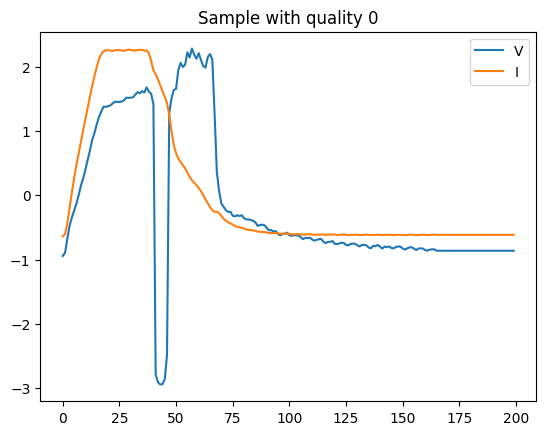

In [9]:
# one input sample
print(f"One input sample shape {train_x[0].shape}")
plt.plot(train_x[0, :, 0], label="V")
plt.plot(train_x[0, :, 1], label="I")
plt.title(f"Sample with quality {int(train_y[0])}")
plt.legend()
plt.show()

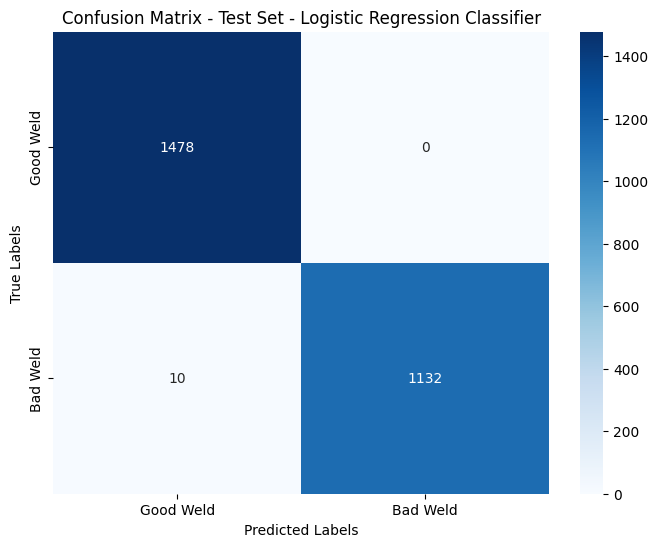


Validation Accuracy: 0.7016268605053652
Test Accuracy: 0.9961832061068703
Classification Report - Test Set:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1478
           1       1.00      0.99      1.00      1142

    accuracy                           1.00      2620
   macro avg       1.00      1.00      1.00      2620
weighted avg       1.00      1.00      1.00      2620

Confusion Matrix - Test Set:
[[1478    0]
 [  10 1132]]
Cross-validation scores: [0.71328244 0.71563836 0.712584   0.69945021 0.70311546]
Average cross-validation score: 0.7088140939253055


In [16]:
# Logistic Regression

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

train_x_lr = train_x.reshape(train_x.shape[0], -1)
val_x_lr = val_x.reshape(val_x.shape[0], -1)
test_x_lr = test_x.reshape(test_x.shape[0], -1)

lr_classifier = LogisticRegression(max_iter=5000)
lr_classifier.fit(train_x_lr, train_y)

val_predictions = lr_classifier.predict(val_x_lr)
test_predictions = lr_classifier.predict(test_x_lr)

val_accuracy = accuracy_score(val_y, val_predictions)
test_accuracy = accuracy_score(test_y, test_predictions)

test_cm = confusion_matrix(test_y, test_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True,cmap='Blues',fmt='d')
plt.title('Confusion Matrix - Test Set - Logistic Regression Classifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks([0.5, 1.5], ['Good Weld', 'Bad Weld'])
plt.yticks([0.5, 1.5], ['Good Weld', 'Bad Weld'])
plt.show()
print()

test_classification_report = classification_report(test_y, test_predictions)

cv_scores = cross_val_score(lr_classifier, train_x_lr, train_y, cv=5)
average_cv_score = cv_scores.mean()

print('Validation Accuracy:', val_accuracy)
print('Test Accuracy:', test_accuracy)
print('Classification Report - Test Set:')
print(test_classification_report)
print('Confusion Matrix - Test Set:')
print(test_cm)
print("Cross-validation scores:", cv_scores)
print("Average cross-validation score:", average_cv_score)

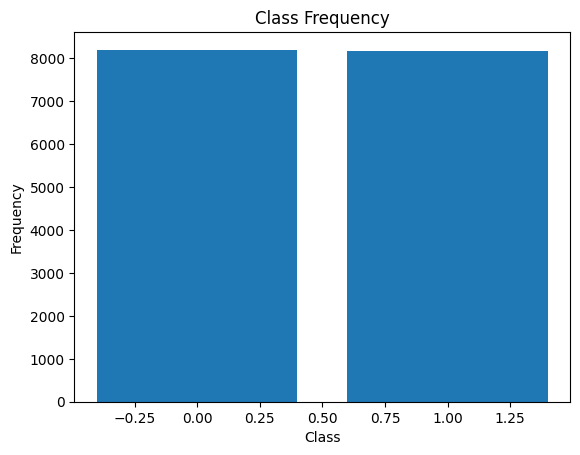

In [17]:
"""
Examine the distribution of your target variable to determine whether to use 'balanced' or None for 'class_weight'.
If the classes are unbalanced, 'balanced' can improve model performance; if the classes are roughly equal, 'class_weight' should be set to None.
"""
import numpy as np
import matplotlib.pyplot as plt

unique, counts = np.unique(train_y, return_counts=True)

plt.bar(unique, counts)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [18]:
# Hyperparameter Tuning for Logistic Regression Algorithm

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Reshape data
train_x_lr = train_x.reshape(train_x.shape[0], -1)
val_x_lr = val_x.reshape(val_x.shape[0], -1)
test_x_lr = test_x.reshape(test_x.shape[0], -1)

# Scale data
scaler = StandardScaler()

train_x_lr_scaled = scaler.fit_transform(train_x_lr)
val_x_lr_scaled = scaler.transform(val_x_lr)
test_x_lr_scaled = scaler.transform(test_x_lr)

# Initialize your LogisticRegression
lr_classifier = LogisticRegression()

# Grid search parameters
param_grid = {'penalty' : ['l1','l2'],
              'C': np.logspace(-3, 3, 10),
              'solver' : ['saga'],
              'max_iter' : [2000, 5000],
              'class_weight': ['balanced', None],
             }

grid_search = GridSearchCV(lr_classifier, param_grid, cv=5, verbose=2, n_jobs=-1)

grid_search.fit(train_x_lr_scaled, train_y)

best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")

val_predictions_lr = grid_search.best_estimator_.predict(val_x_lr_scaled)
test_predictions_lr = grid_search.best_estimator_.predict(test_x_lr_scaled)

val_accuracy_lr = accuracy_score(val_y, val_predictions_lr)
test_accuracy_lr = accuracy_score(test_y, test_predictions_lr)

print(f"Validation accuracy with best estimator: {val_accuracy_lr}")
print(f"Test accuracy with best estimator: {test_accuracy_lr}")


Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best parameters: {'C': 0.001, 'class_weight': None, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'saga'}
Validation accuracy with best estimator: 0.706472827968155
Test accuracy with best estimator: 0.999618320610687
